In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils import Spectrum
from specutils.manipulation import FluxConservingResampler
import xarray as xr

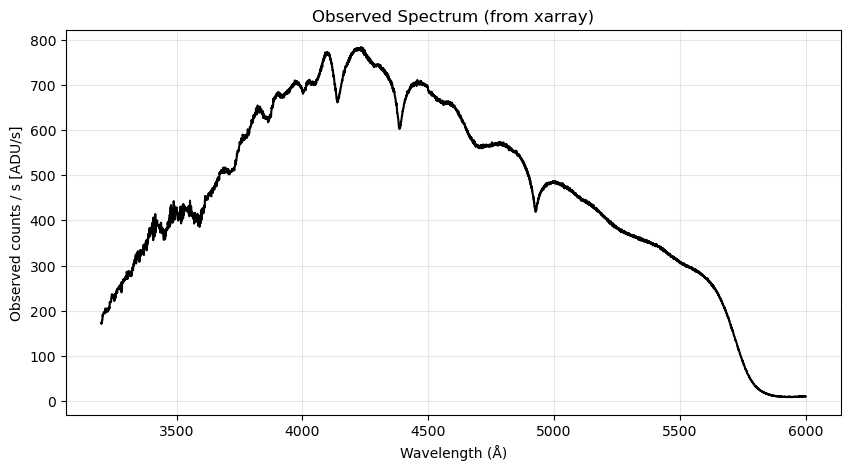

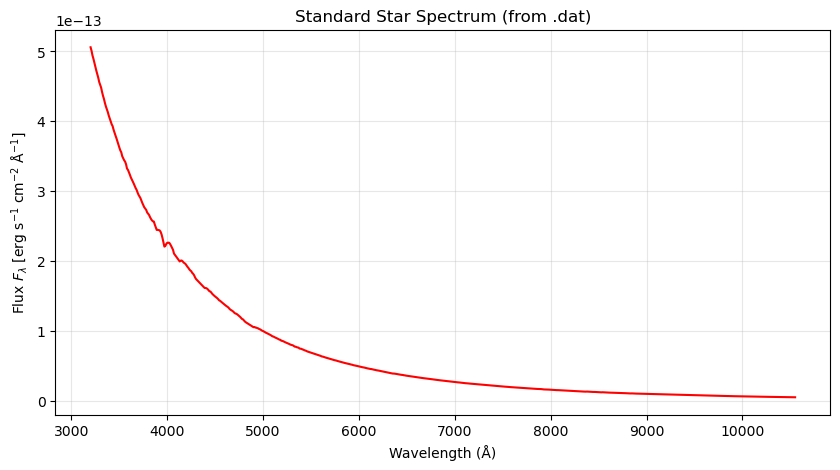

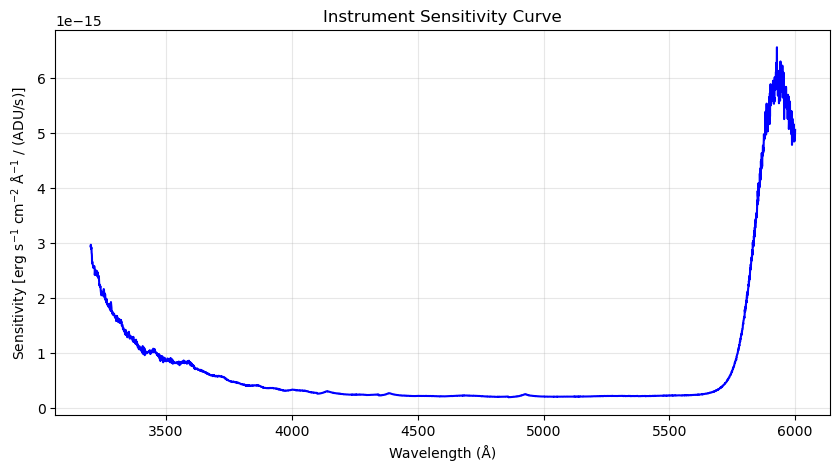

In [7]:
# -------------------------------
# 1. Load observed spectrum from xarray
# -------------------------------
# Example: your spectra file (HDF5/NetCDF)
ds = xr.open_dataset("D:/Pavlicek, Emma/G191B2B/blue/blue_mods2b_spectra.h5", engine="h5netcdf")

# Pick one exposure (e.g., first one)
wavelengths = ds['wavelength'].values * u.AA
flux = ds['flux'].values[0, :] * u.adu      # counts
exptime = 90.0 * u.s
flux_rate = flux / exptime                   # ADU / s

observed_spectrum = Spectrum(
    spectral_axis=wavelengths,
    flux=flux_rate
)

# -------------------------------
# 2. Load standard star AB magnitude table (.dat)
# -------------------------------
# Load wavelength and ABmag (ignore error column)
std_wave, std_abmag = np.loadtxt(
    "D:/Pavlicek, Emma/G191B2B/g191b2b_10a_fluxtable.dat",
    usecols=(0, 1), unpack=True
)

std_wave = std_wave * u.AA   # wavelength in Angstrom

# 1) Convert AB magnitude -> F_nu  [erg s^-1 cm^-2 Hz^-1]
#    m_AB = -2.5 log10(F_nu) - 48.6  =>  F_nu = 10^(-0.4 * (m_AB + 48.6))
std_flux_fnu = (10.0 ** (-0.4 * (std_abmag + 48.6))) * u.erg / (u.s * u.cm**2 * u.Hz)

# 2) Convert F_nu -> F_lambda at each wavelength
#    Use astropy spectral-density equivalency so units stay correct
std_wave_q = std_wave.to(u.AA)  # ensure Quantity
std_flux_flambda = std_flux_fnu.to(
    u.erg / (u.s * u.cm**2 * u.AA),
    equivalencies=u.spectral_density(std_wave_q)
)

# 3) Wrap as a Spectrum1D you can resample to your observed wavelengths
true_spectrum = Spectrum(
    spectral_axis=std_wave_q,
    flux=std_flux_flambda
)

# -------------------------------
# 3. Resample standard star to observed wavelengths
# -------------------------------
resampler = FluxConservingResampler()
true_flux_interp = resampler(true_spectrum, wavelengths)

# -------------------------------
# 4. Sensitivity curve
# -------------------------------
sensitivity_curve = true_flux_interp.flux / observed_spectrum.flux

# -------------------------------
# 5. QA PLOTS
# -------------------------------

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, flux_rate.value, color="black")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Observed counts / s [ADU/s]")
plt.title("Observed Spectrum (from xarray)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(std_wave, std_flux_flambda.value, color="red")
plt.xlabel("Wavelength (Å)")
plt.ylabel(r"Flux $F_\lambda$ [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]")
plt.title("Standard Star Spectrum (from .dat)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, sensitivity_curve.value, color="blue")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Sensitivity [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ / (ADU/s)]")
plt.title("Instrument Sensitivity Curve")
plt.grid(alpha=0.3)
plt.show()

In [10]:

# Example dataset
ds2 = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/Blue/SDSS1411_blue_mods2b_spectra.h5", engine="h5netcdf")
# dimensions: time x wavelength
target_wavelengths = ds2['wavelength']  # shape: (nwavelength,)
flux = ds2['flux']  # shape: (ntime, nwavelength)
exposure_time = 600.0 # seconds
flux_error = ds2["flux_error"]


In [11]:
from scipy.interpolate import interp1d

# Build interpolator from your sensitivity curve
sensitivity_curve_interp = interp1d(wavelengths.value,
                                   sensitivity_curve.value,
                                   bounds_error=False,
                                   fill_value="extrapolate")

# --- Apply calibration ---
target_counts = flux / exposure_time
err_counts = flux_error / exposure_time
flux_calibrated = target_counts * sensitivity_curve_interp(target_wavelengths)
flux_error_calibrated = err_counts * sensitivity_curve_interp(target_wavelengths)

flux_error_da = xr.DataArray(
    flux_error_calibrated,
    dims=("time", "wavelength"),
    coords={
        "time": ds2["time"],
        "wavelength": ds2["wavelength"]
    },
    attrs={"units": "erg/s/cm^2/Å", "description": "1-sigma error on calibrated flux"}
)

# --- Build a new xarray Dataset with calibrated flux ---
flux_calibrated_da = xr.DataArray(
    flux_calibrated.values,
    dims=("time", "wavelength"),
    coords={
        "time": ds2["time"],
        "wavelength": ds2["wavelength"]
    },
    attrs={"units": "erg/s/cm^2/Å"}  # optional
)

ds_calibrated = xr.Dataset(
    {
        "flux_calibrated": flux_calibrated_da,
        "flux_calibrated_error": flux_error_da
    },
    coords={
        "time": ds2["time"],
        "wavelength": ds2["wavelength"]
    },
    attrs=ds2.attrs
)

ds_calibrated.attrs["calibrated_with"] = "sensitivity_curve_blue_mod2b"

# --- Save to a new HDF5 file ---
ds_calibrated.to_netcdf("D:/Pavlicek, Emma/SDSS1411/Blue/calibrated_mod2b.nc", engine="h5netcdf")
